# Deutsch-Jozsa
The Deutsch-Jozsa algorithim is one of the first examples of how a quantum algorithm can outperform classical computing on a specific task.

## What is Deutsch-Jozsa
Given a function which takes an *n-bit string* and outputs either 0 or 1:
$f:\{0,1\}^n\to\{0,1\}$
You are promised that f is one of two types:
* **Constant**: returns the same value for all inputs.
* **Balanced**: returns 0 for half of the inputs and 1 for the other half.

### Classically difficult
In the worst case you'd have to check $2^{n-1}+1$ inputs to be sure it was balanced or constant. You might keep getting the same output until you test one more input to see if it changes. So, logically, you have to test at least half of all n-length inputs.

### Quantum Advantage
The Deutsch-Jozsa algorithm can determine the answer with just one evaluation of $f$ using superposition.

Instead of testing one at a time, you evaluate f(x) for all possible x simultaneously!

The single oracle invocation acts on all inputs at once. Applying it on the input register in superposition applies $f(x)$ for every x.

After the oracle, more Hadamards make amplitudes interfere constructively or destructively depending on the structure of $f$.

The speedup is about query complexity, not necessarily total runtime.

## Oracle Structures
For 1, 2, and 3 qubits.

TODO: finish this section

## High-Level Implementation
* Prepare $n$ qubits in state $\ket{0}$ and one auxiliary qubit in $\ket{1}$: $$\ket{0}^{\otimes{n}}\ket{1}$$
* Apply Hadamard gates on all qubits to create superpositions of all possible inputs.
* Apply the oracle $U_f$. to flip the phase of states for $f(x) = 1$.
* Apply Hadamard gates on the first *n* qubits to transform the phase information into measurable amplitudes.
* Measure the first n qubits. If $f$ is constant, the result is $\ket{0}^{\otimes{n}}$. If $f$ is balance the result is anything else.

In [21]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from math import log2
import matplotlib.pyplot as plt

In [15]:
def deutsch_jozsa_circuit(oracle, n):
	# the oracle is a quantum circuit acting on n qubits + 1 ancilla.
	circuit = QuantumCircuit(n+1, n)
	# initialize input to n zero states and one 1 state
	# by applying NOT to the nth index.
	circuit.x(n)
	# apply H to all qubits
	circuit.h(range(n+1))
	# append oracle
	circuit.compose(oracle, inplace=True)
	# apply H to first n qubits
	circuit.h(range(n))
	# measure input qubits
	circuit.measure(range(n), range(n))
	return circuit

In [16]:
# Oracles for n = 1
def oracle_constant_zero_n1():
    # identity: does nothing (total qubits = 2)
    return QuantumCircuit(2)

def oracle_constant_one_n1():
    qc = QuantumCircuit(2)
    qc.x(1)   # flip ancilla => y -> y XOR 1
    return qc

def oracle_balanced_identity_n1():
    # f(x) = x  -> CNOT from qubit 0 to ancilla (qubit 1)
    qc = QuantumCircuit(2)
    qc.cx(0, 1)
    return qc

# Build and test
oracles_n1 = {
    'const0': oracle_constant_zero_n1(),
    'const1': oracle_constant_one_n1(),
    'balanced_x': oracle_balanced_identity_n1()
}

In [17]:
# Oracles for n = 2
def oracle_constant_zero_n2():
    return QuantumCircuit(3)

def oracle_constant_one_n2():
    qc = QuantumCircuit(3)
    qc.x(2)
    return qc

def oracle_parity_n2():
    # f(x0,x1) = x0 XOR x1  -> CNOT from each input to ancilla (qubit 2)
    qc = QuantumCircuit(3)
    qc.cx(0,2)
    qc.cx(1,2)
    return qc

def oracle_projection_q0_n2():
    # f(x) = x0
    qc = QuantumCircuit(3)
    qc.cx(0,2)
    return qc

oracles_n2 = {
    'const0': oracle_constant_zero_n2(),
    'const1': oracle_constant_one_n2(),
    'parity': oracle_parity_n2(),
    'proj_q0': oracle_projection_q0_n2()
}

In [18]:
# Oracles for n = 3
def oracle_constant_zero_n3():
    return QuantumCircuit(4)

def oracle_constant_one_n3():
    qc = QuantumCircuit(4)
    qc.x(3)
    return qc

def oracle_parity_n3():
    # f(x0,x1,x2) = x0 XOR x1 XOR x2
    qc = QuantumCircuit(4)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)
    return qc

def oracle_proj_q1_n3():
    # f(x) = x1
    qc = QuantumCircuit(4)
    qc.cx(1,3)
    return qc

oracles_n3 = {
    'const0': oracle_constant_zero_n3(),
    'const1': oracle_constant_one_n3(),
    'parity3': oracle_parity_n3(),
    'proj_q1': oracle_proj_q1_n3()
}

Results for n=1 const0:
{'0': 1024}


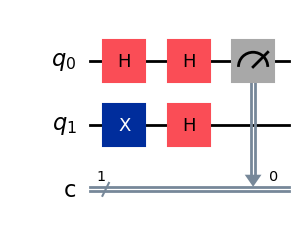

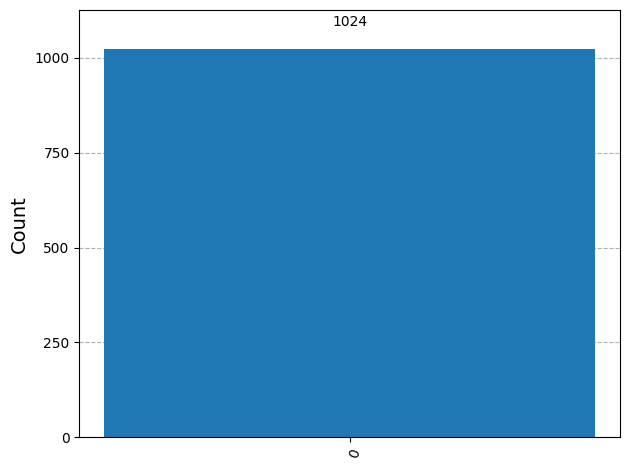

Results for n=1 const1:
{'0': 1024}


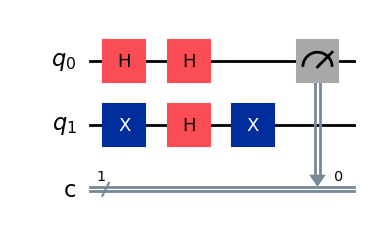

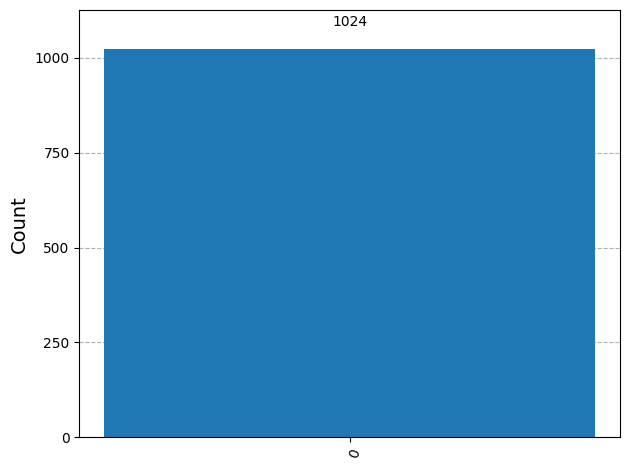

Results for n=1 balanced_x:
{'1': 1024}


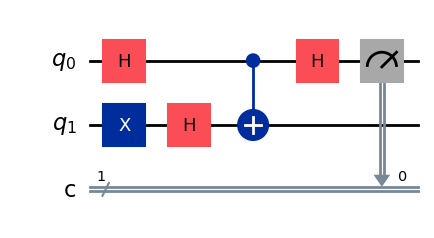

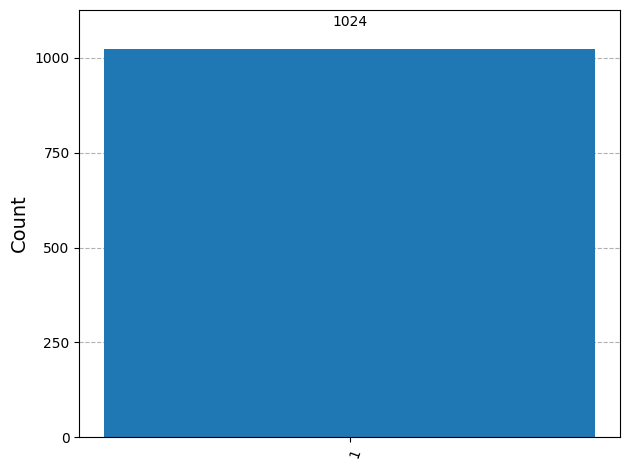

Results for n=2 const0:
{'00': 1024}


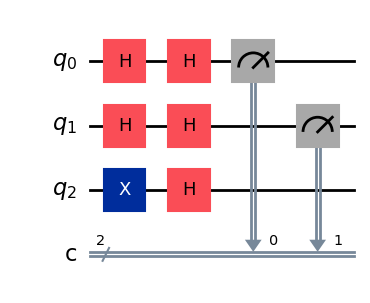

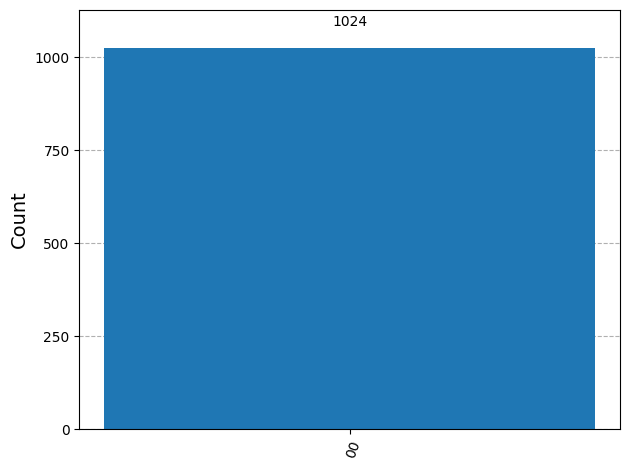

Results for n=2 const1:
{'00': 1024}


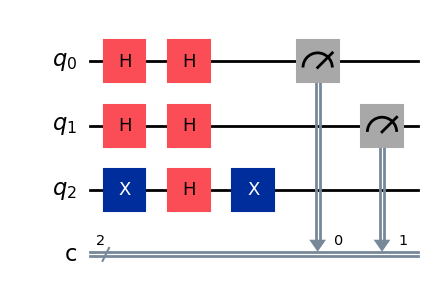

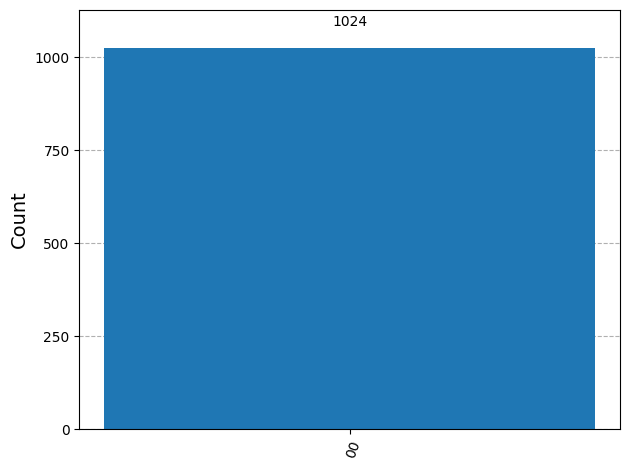

Results for n=2 parity:
{'11': 1024}


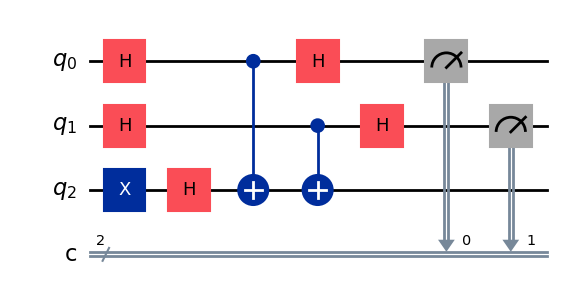

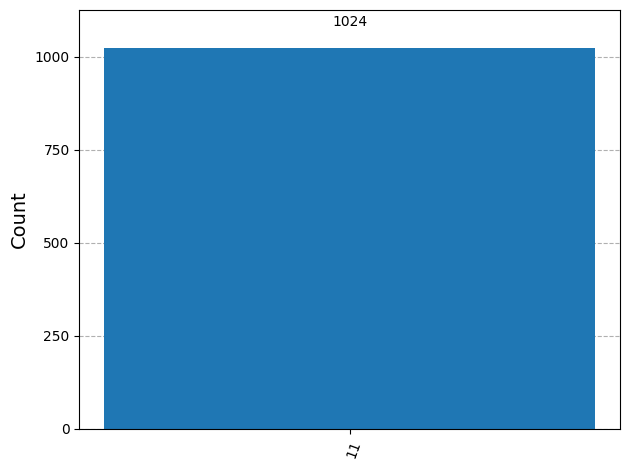

Results for n=2 proj_q0:
{'01': 1024}


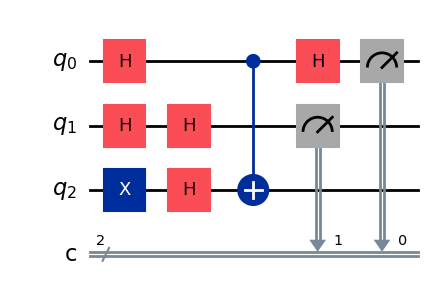

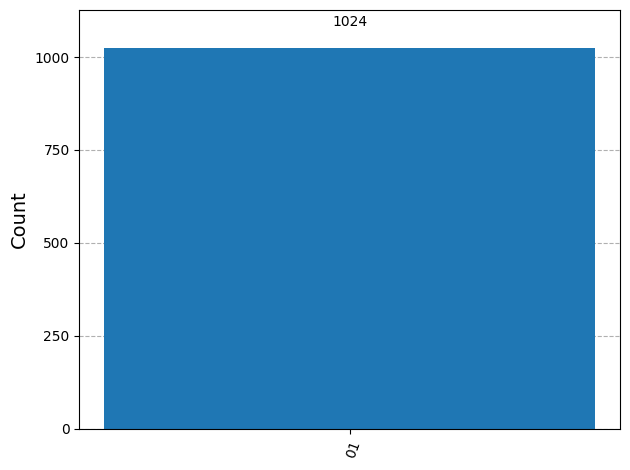

Results for n=3 const0:
{'000': 1024}


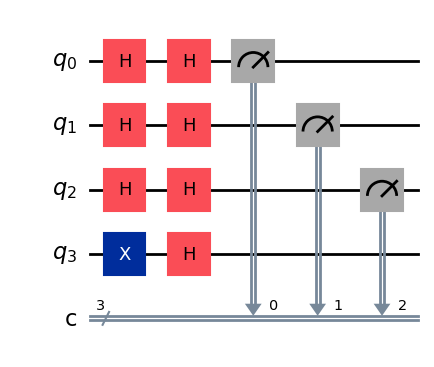

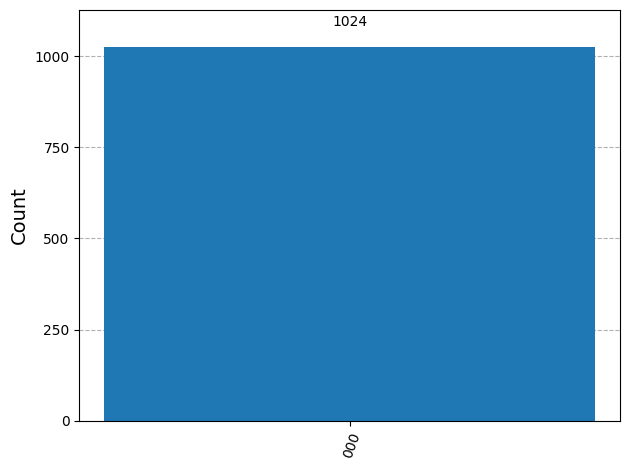

Results for n=3 const1:
{'000': 1024}


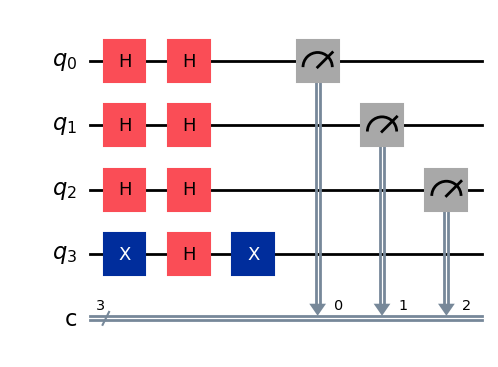

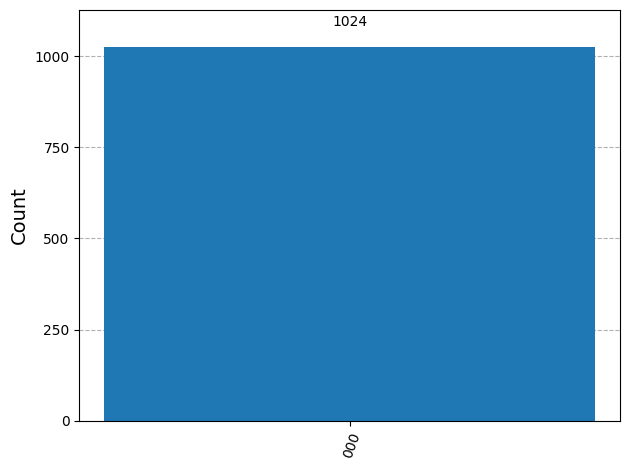

Results for n=3 parity3:
{'111': 1024}


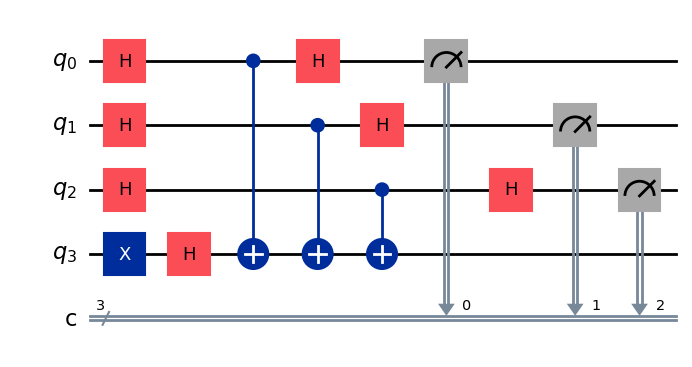

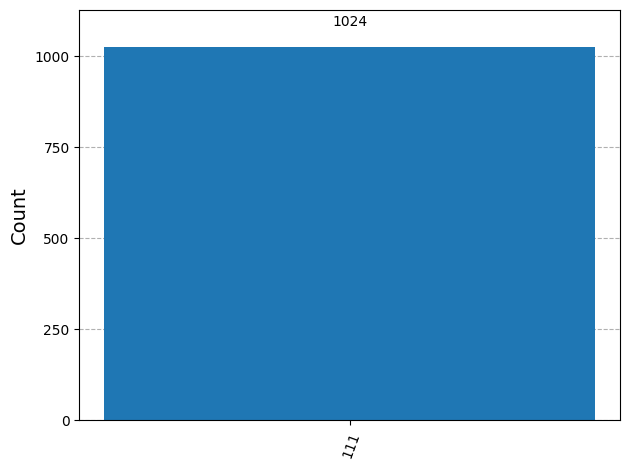

Results for n=3 proj_q1:
{'010': 1024}


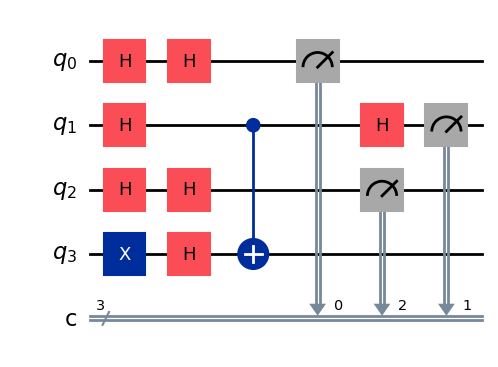

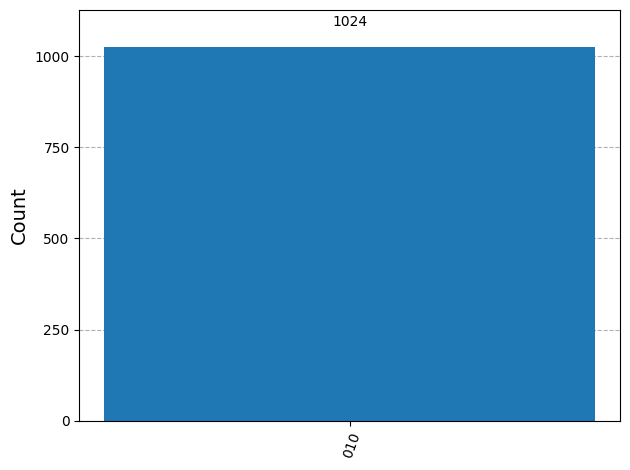

In [27]:
sampler = Sampler()

def run_and_plot(oracle, n, title=''):
    dj_qc = deutsch_jozsa_circuit(oracle, n)
    # transpile / convert to qasm for simulator
    # execute
    job = sampler.run([dj_qc], shots=1024)
    result = job.result()
    counts = result[0].data.c.get_counts()
    print(f"Results for {title}:")
    print(counts)
    display(dj_qc.draw('mpl'))
    display(plot_histogram(counts))
    return counts

# Example runs:
for name, oracle in oracles_n1.items():
    run_and_plot(oracle, 1, title=f'n=1 {name}')

for name, oracle in oracles_n2.items():
    run_and_plot(oracle, 2, title=f'n=2 {name}')

for name, oracle in oracles_n3.items():
    run_and_plot(oracle, 3, title=f'n=3 {name}')
